# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

**Name:** Briain O'Donnell

## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math
from itertools import combinations

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score

%matplotlib inline
#%qtconsole

ModuleNotFoundError: No module named 'sklearn.cross_validation'

### Instantiating Model Parameters 

In [2]:
model_test_accuracy_comparisons = dict()
model_cv_test_mean_accuracy_comparisons = dict()
model_cv_test_std_dev_accuracy_comparisons = dict()
cv_folds = 4

### Loading into the Data

In [3]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

### Data Manipulation

In [4]:
# Downsizing the dataset
train = train.groupby('label', as_index=False).apply(lambda x: x.sample(160)).reset_index(drop=True)
test = test.groupby('label', as_index=False).apply(lambda x: x.sample(40)).reset_index(drop=True)

# Isolating the training dataset
X_train = train[train.columns[1:]]
y_train = np.array(train["label"])

# Isolating the test dataset
X_test = test[test.columns[1:]]
y_test = np.array(test["label"])

# Normalising the dataset
X_train = X_train/255
X_test = X_test/255

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [5]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

### Model 1. StackedEnsembleClassifier Class
#### 1.1 Logistic Regression Stack Layer

In [6]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierLogReg(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and an aggregation model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each base estimator (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
                  
        # Train each base classifier and generate the stack layer training dataset
            # self.classifiers_ contains each of the newly created classifiers
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)
            
            # Append the predictions to the stack layer training set (a bit of hacking here!)
                # We are using the x data and the corresponding y predictions as the new training data in the stack layer 
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
                        
        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)

        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
        
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])
    
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

#### 1.2 Decision Trees Stack Layer

In [7]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierTrees(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "tree"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each base estimator (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
                  
        # Train each base classifier and generate the stack layer training dataset
            # self.classifiers_ contains each of the newly created classifiers
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)
            
            # Append the predictions to the stack layer training set (a bit of hacking here!)
                # We are using the x data and the corresponding y predictions as the new training data in the stack layer 
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
                        
        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)

        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
        
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])
    
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

### Test the StackedEnsembleClassifier

#### 1.1 Logistic Regression Stack Layer

In [8]:
clf = StackedEnsembleClassifierLogReg()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Original - LogReg"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Original - LogReg"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Original - LogReg"] = accuracy

(1600, 240)
(1600,)
(300, 240)
(300,)
(300, 240)
(300,)
(300, 240)
(300,)
(300, 240)
(300,)


#### 1.2 Decision Trees Stack Layer

In [9]:
clf = StackedEnsembleClassifierTrees()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Original - Trees"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Original - Trees"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Original - Trees"] = accuracy

(1600, 240)
(1600,)
(300, 240)
(300,)
(300, 240)
(300,)
(300, 240)
(300,)
(300, 240)
(300,)


---

## Task 1: Design the StackedEnsembleHoldOut Class

### Model 2: StackedEnsembleHoldOut
#### 2.1 Logistic Regression Stack Layer

In [10]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierHoldOutLogReg(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each classifier (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Split up training data into train / test set to train the base classifiers
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
          
        # Train each base classifier and generate the stack layer training dataset
        for classifier in self.classifiers_:
            
            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the test set
            y_pred = classifier.predict_proba(X_test) 

            # Append the predictions to the stack layer training set (a bit of hacking here!)
                # We are using the y predictions as the new training data in the stack layer 
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)

        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split = math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

#### 2.2 Decision Trees Stack Layer

In [11]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierHoldOutTrees(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "tree"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each classifier (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Split up training data into train / test set to train the base classifiers
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
          
        # Train each base classifier and generate the stack layer training dataset
        for classifier in self.classifiers_:
            
            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the test set
            y_pred = classifier.predict_proba(X_test) 

            # Append the predictions to the stack layer training set (a bit of hacking here!)
                # We are using the y predictions as the new training data in the stack layer 
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)

        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split = math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

### Test the StackedEnsembleClassifierHoldOut

#### 2.1 Logistic Regression Stack Layer

In [12]:
clf = StackedEnsembleClassifierHoldOutLogReg()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Hold Out - LogReg"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Hold Out - LogReg"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Hold Out - LogReg"] = accuracy

(320, 240)
(320,)
(60, 240)
(60,)
(60, 240)
(60,)
(60, 240)
(60,)
(60, 240)
(60,)


#### 2.2 Decision Trees Stack Layer

In [13]:
clf = StackedEnsembleClassifierHoldOutTrees()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Hold Out - Trees"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Hold Out - Trees"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Hold Out - Trees"] = accuracy

(320, 240)
(320,)
(60, 240)
(60,)
(60, 240)
(60,)
(60, 240)
(60,)
(60, 240)
(60,)


## Task 2: Design the StackedEnsembleKFold Class

### Model 3: StackedEnsembleKFold
#### 3.1 Logistic Regression Stack Layer

In [14]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierKFoldLogReg(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and an aggregation model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each classifier (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
         
        # Train each base classifier and generate the stack layer training dataset
        for classifier in self.classifiers_:
            
            kf = KFold(X.shape[0], n_folds=5, random_state=0)
            
            self.X_stack_train_cv = None 
        
            for i, (train_index, test_index) in enumerate(kf):
                X_train_kf = X[train_index]
                y_train_kf = y[train_index]
                X_test_kf = X[test_index]

                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X_train_kf, y_train_kf, replace=True)    

                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)

                # Make predictions for all instances in the test set
                y_pred_kf = classifier.predict_proba(X_test_kf)

                # Append the predictions to the stack layer training set (a bit of hacking here!)
                    # We are using the y predictions as the new training data in the stack layer 
                try:
                    self.X_stack_train_cv = np.r_[self.X_stack_train_cv, y_pred_kf]
                except ValueError:
                    self.X_stack_train_cv = y_pred_kf
               
            try:
                self.X_stack_train = np.c_[self.X_stack_train, self.X_stack_train_cv]
            except ValueError:
                self.X_stack_train = self.X_stack_train_cv

        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)
                          
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

#### 3.2 Decision Trees Stack Layer

In [15]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierKFoldTrees(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and an aggregation model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "tree"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
        
        # Run each type of classifiers 8 times 
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                # Append each classifier (8x3) to the list and create each classifier as we go
                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
         
        # Train each base classifier and generate the stack layer training dataset
        for classifier in self.classifiers_:
            
            kf = KFold(X.shape[0], n_folds=5, random_state=0)
            
            self.X_stack_train_cv = None 
        
            for i, (train_index, test_index) in enumerate(kf):
                X_train_kf = X[train_index]
                y_train_kf = y[train_index]
                X_test_kf = X[test_index]

                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X_train_kf, y_train_kf, replace=True)    

                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)

                # Make predictions for all instances in the test set
                y_pred_kf = classifier.predict_proba(X_test_kf)

                # Append the predictions to the stack layer training set (a bit of hacking here!)
                    # We are using the y predictions as the new training data in the stack layer 
                try:
                    self.X_stack_train_cv = np.r_[self.X_stack_train_cv, y_pred_kf]
                except ValueError:
                    self.X_stack_train_cv = y_pred_kf
               
            try:
                self.X_stack_train = np.c_[self.X_stack_train, self.X_stack_train_cv]
            except ValueError:
                self.X_stack_train = self.X_stack_train_cv

        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)
                          
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

### Test the StackedEnsembleClassifierKFold

#### 3.1 Logistic Regression Stack Layer

In [16]:
clf = StackedEnsembleClassifierKFoldLogReg()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["K Fold - LogReg"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["K Fold - LogReg"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["K Fold - LogReg"] = accuracy

(1600, 192)
(1600,)
(300, 192)
(300,)
(300, 192)
(300,)
(300, 192)
(300,)
(300, 192)
(300,)


#### 3.2 Decision Trees Stack Layer

In [17]:
clf = StackedEnsembleClassifierKFoldTrees()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["K Fold - Trees"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["K Fold - Trees"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["K Fold - Trees"] = accuracy

(1600, 192)
(1600,)
(300, 192)
(300,)
(300, 192)
(300,)
(300, 192)
(300,)
(300, 192)
(300,)


## Task 3: Compare the Performance of Different Stack Layer Approaches

{'Original - LogReg': 0.785,
 'Original - Trees': 0.7775,
 'Hold Out - LogReg': 0.7825,
 'Hold Out - Trees': 0.635,
 'K Fold - LogReg': 0.375,
 'K Fold - Trees': 0.295}

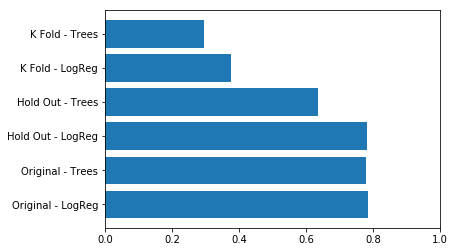

In [18]:
display(model_test_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

{'Original - LogReg': 0.7424999999999999,
 'Original - Trees': 0.7125,
 'Hold Out - LogReg': 0.7325,
 'Hold Out - Trees': 0.55,
 'K Fold - LogReg': 0.3825,
 'K Fold - Trees': 0.27749999999999997}

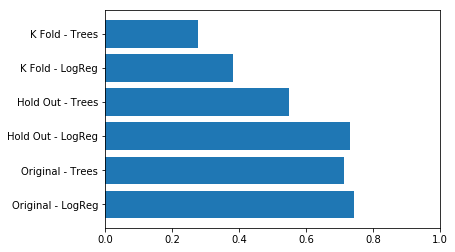

In [19]:
display(model_cv_test_mean_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_test_mean_accuracy_comparisons)), list(model_cv_test_mean_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_test_mean_accuracy_comparisons)), list(model_cv_test_mean_accuracy_comparisons.keys()))

{'Original - LogReg': 0.014790199457749054,
 'Original - Trees': 0.027726341266023535,
 'Hold Out - LogReg': 0.04968651728587948,
 'Hold Out - Trees': 0.05385164807134504,
 'K Fold - LogReg': 0.047631397208144126,
 'K Fold - Trees': 0.0511737237261468}

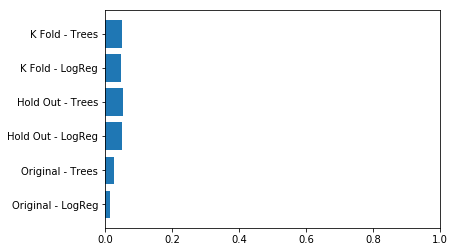

In [20]:
display(model_cv_test_std_dev_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_test_std_dev_accuracy_comparisons)), list(model_cv_test_std_dev_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_test_std_dev_accuracy_comparisons)), list(model_cv_test_std_dev_accuracy_comparisons.keys()))

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

#### Splitting up the Dataset

In [21]:
X_train_plus_valid = X_train.copy()
y_train_plus_valid = y_train.copy()

X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train_plus_valid, 
                                                              y_train_plus_valid, 
                                                              random_state=0,
                                                              train_size = 0.7)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Model 4: Single Decision Tree Model

In [22]:
# Fitting the inital tree on the training data
my_tree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=100)
my_tree.fit(X_train_new, y_train_new)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Make a set of predictions for the test data

In [23]:
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["Simple Decision Tree - Untuned"] = accuracy

scores = cross_val_score(my_tree, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Single Decision Tree - Untuned"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Single Decision Tree - Untuned"] = np.std(scores)

#### Set up the a parameter grid to search

In [24]:
param_grid = {'criterion': ['gini', "entropy"], \
              'max_depth': list(range(3, 100, 30)), \
              'min_samples_split': [2,100,200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(),
                             param_grid, cv=cv_folds, verbose = 2,
                             return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[C

[CV]  criterion=gini, max_depth=15, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.4s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.7s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.7s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=30, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=30, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=30, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=30, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=30, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.5s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.4s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.4s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.4s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=45, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=45, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=45, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=45, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=45, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.5s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.5s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ............

[CV]  criterion=gini, max_depth=60, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=60, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=60, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=60, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=60, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=60, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=60, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=60, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=60, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=60, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=60, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=60, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=60, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ........

[CV]  criterion=gini, max_depth=75, min_samples_split=2, total=   0.5s
[CV] criterion=gini, max_depth=75, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=75, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=75, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=75, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=100, total=   0.4s
[CV] criterion=gini, max_depth=75, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=75, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=200, total=   0.3s
[CV] criterion=gini, max_depth=75, min_samples_split=200 ........

[CV]  criterion=gini, max_depth=90, min_samples_split=2, total=   0.4s
[CV] criterion=gini, max_depth=90, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=90, min_samples_split=2, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=90, min_samples_split=2, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=100, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_split=200 ............

[CV]  criterion=entropy, max_depth=3, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, total=   0.6s
[CV] criterion=entropy, max_depth=6, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=6, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=6, min_samples_split=10

[CV]  criterion=entropy, max_depth=18, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=18, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=18, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=18, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=18, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=18, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=18, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=21, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=21, min_samples_split=2, total=   0.8s
[CV] criterion=entropy, max_depth=21, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=21, min_samples_split=2, total=   0.7s
[CV] criterion=entropy, max_depth=21, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=21, min_samples_split=2, total=   0.8s
[CV] criterion=entropy, max_depth=21, min_sample

[CV]  criterion=entropy, max_depth=33, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=33, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=33, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=33, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=33, min_samples_split=100, total=   0.5s
[CV] criterion=entropy, max_depth=33, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=33, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=33, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=33, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=33, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=33, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=33, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=33, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=36, min_

[CV]  criterion=entropy, max_depth=48, min_samples_split=2, total=   0.8s
[CV] criterion=entropy, max_depth=48, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=48, min_samples_split=2, total=   0.8s
[CV] criterion=entropy, max_depth=48, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=48, min_samples_split=2, total=   0.9s
[CV] criterion=entropy, max_depth=48, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=100, total=   0.7s
[CV] criterion=entropy, max_depth=48, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=100, total=   0.7s
[CV] criterion=entropy, max_depth=48, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=48, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=48, min_sample

[CV]  criterion=entropy, max_depth=60, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=60, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=60, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=60, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=60, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=63, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=63, min_samples_split=2, total=   0.9s
[CV] criterion=entropy, max_depth=63, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=63, min_samples_split=2, total=   0.8s
[CV] criterion=entropy, max_depth=63, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=63, min_samples_split=2, total=   0.9s
[CV] criterion=entropy, max_depth=63, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=63, min_samples_split=2, total=   0.9s
[CV] criterion=entropy, max_depth=63, min_samples_

[CV]  criterion=entropy, max_depth=75, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=75, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=75, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=75, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=75, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=75, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=75, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=75, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=75, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=75, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=75, min_samples_split=200, total=   0.4s
[CV] criterion=entropy, max_depth=78, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=78, min_samples_split=2, total=   0.9s
[CV] criterion=entropy, max_depth=78, min_sa

[CV]  criterion=entropy, max_depth=90, min_samples_split=2, total=   1.1s
[CV] criterion=entropy, max_depth=90, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=90, min_samples_split=2, total=   1.0s
[CV] criterion=entropy, max_depth=90, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=90, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=90, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=90, min_samples_split=100, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=90, min_samples_split=100, total=   0.7s
[CV] criterion=entropy, max_depth=90, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=90, min_samples_split=200, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samp

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:  7.5min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99], 'min_samples_split': [2, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

#### Generate Predictions for the Test Set using Tuned Tree

In [25]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

scores = cross_val_score(my_tuned_tree, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Single Decision Tree - Tuned"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Single Decision Tree - Tuned"] = np.std(scores)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Simple Decicision Tree - Tuned"] = accuracy

Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=60, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 ............

[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=10

[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_

[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_

[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_

[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   59.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criter

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............


[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=10

[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samp

[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_sa

[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_

[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   57.3s finished


Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 .............

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 ..........

[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=

[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_

[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samp

[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_sa

[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_

[CV]  criterion=entropy, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   56.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[C

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=30, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=45, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=45, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=45, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=60, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 ............

[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=10

[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_

[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_

[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_

[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samp

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   58.4s finished


### Model 5: Ensemble based on Bagging

In [26]:
# Fitting the inital tree on the training data
my_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy"),
                                      n_estimators=10)
my_model.fit(X_train_new, y_train_new)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

#### Make a set of predictions for the test data

In [27]:
y_pred = my_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["Bagging Ensemble - Untuned"] = accuracy

scores = cross_val_score(my_tuned_tree, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Bagging Ensemble - Untuned"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Bagging Ensemble - Untuned"] = np.std(scores)

Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 ........

[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............


[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=10

[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.3s
[CV] criterion=entropy, max_depth=39, min_samp

[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_

[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_

[CV]  criterion=entropy, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[C

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 ............

[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=10

[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_

[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_

[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_

[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   54.4s finished


Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=2 ................

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 ........

[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ......

[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ......

[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ............

[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ............

[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............


[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=12, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=12, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_s

[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_sample

[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=42, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=42, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=42, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=42, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=42, min_samp

[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_

[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_

[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   59.9s finished


Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=2 ................

[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=21, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=21, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=21, min_samples_split=2 ..........

[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=51, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=51, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=51, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=51, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=200 ............

[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=12, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=12, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=12, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=12, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=12, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples_s

[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=27, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=27, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=27, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=27, min_samples_

[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=42, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=42, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=42, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=42, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=42, min_samp

[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_

[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_sample

[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=84, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_

[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=99, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:  1.1min finished


#### Set up the a parameter grid to search

In [28]:
param_grid = [
 {'n_estimators': list(range(10, 50, 10)),
 'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy"),
                    tree.DecisionTreeClassifier(criterion="gini")]
 }]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10, total=   7.1s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_node

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10, total=   7.3s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=10 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=40, total=  23.5s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=40 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=20, total=   5.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=30 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=No

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  6.7min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40], 'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_sam...     min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

#### Generate Predictions for the Test Set using Tuned Tree

In [29]:
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["Bagging Ensemble - Tuned"] = accuracy

scores = cross_val_score(my_tuned_tree, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["Bagging Ensemble - Tuned"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["Bagging Ensemble - Tuned"] = np.std(scores)

Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=6, min_samples_split=2 ................

[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=21, min_samples_split=2 ........

[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=36, min_samples_split=2 ............

[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=51, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=51, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=51, min_samples_split=2 ............

[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=66, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=66, min_samples_split=100 .............


[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=81, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=81, min_samples_split=2, total=   0.0s


[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=96, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=96, min_samples_split=2 ............

[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=12, min_samples

[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samp

[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_

[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=54, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_

[CV]  criterion=entropy, max_depth=66, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=69, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=69, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=69, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=69, min_samples_

[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=84, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=84, min_samples_

[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=99, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=99, min_samp

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............


[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=9, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=10

[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_

[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=39, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=39, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=39, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=39, min_samples_

[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=54, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=54, min_samp

[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=66, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_sa

[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=81, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=81, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_samples_

[CV]  criterion=entropy, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=96, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=96, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=96, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=96, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   56.5s finished


Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ............

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............


[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.1s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s


[CV]  criterion=gini, max_depth=75, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=75, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=75, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=75, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=90, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=90, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=90, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=90, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=90, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ............

[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=100 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_

[CV]  criterion=entropy, max_depth=21, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=21, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=21, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=21, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samp

[CV]  criterion=entropy, max_depth=36, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_

[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=48, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_

[CV]  criterion=entropy, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samp

[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_

[CV]  criterion=entropy, max_depth=93, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=93, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=93, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=93, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=93, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=93, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=93, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:  1.1min finished


Fitting 4 folds for each of 198 candidates, totalling 792 fits
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=2 ................
[CV] . criterion=gini, max_depth=3, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=100 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............

[CV]  criterion=gini, max_depth=18, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=18, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=18, min_samples_split=200 ........

[CV]  criterion=gini, max_depth=33, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=33, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=33, min_samples_split=200 ........

[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=48, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=48, min_samples_split=200 ..........

[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=63, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=63, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=63, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=75, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=78, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............
[CV]  criterion=gini, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=gini, max_depth=78, min_samples_split=100 .............


[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=90, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=90, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=90, min_samples_split=200, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=93, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_depth=93, min_samples_split=100 .............


[CV]  criterion=entropy, max_depth=6, min_samples_split=100, total=   0.1s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=6, min_samples_split=200 ...........
[CV]  criterion=entropy, max_depth=6, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=9, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=9, min_samples_split=2, total=   0.2s
[CV] criterion=entropy, max_depth=9, min_samples_spli

[CV]  criterion=entropy, max_depth=21, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=21, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=21, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=24, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=24, min_sa

[CV]  criterion=entropy, max_depth=36, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=36, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=36, min_samp

[CV]  criterion=entropy, max_depth=48, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=51, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=51, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=51, min_samples_

[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=63, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=63, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=66, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=66, min_sample

[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.1s
[CV] criterion=entropy, max_depth=78, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=100, total=   0.1s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=78, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=78, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=81, min_

[CV]  criterion=entropy, max_depth=93, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=93, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=93, min_samples_split=2, total=   0.1s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=100 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=100, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=93, min_samples_split=200, total=   0.0s
[CV] criterion=entropy, max_depth=93, min_samp

[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:  1.1min finished


#### Compare the Performance against the Three Stacked Trees 

{'Original - LogReg': 0.785,
 'Original - Trees': 0.7775,
 'Hold Out - LogReg': 0.7825,
 'Hold Out - Trees': 0.635,
 'K Fold - LogReg': 0.375,
 'K Fold - Trees': 0.295,
 'Simple Decision Tree - Untuned': 0.67,
 'Simple Decicision Tree - Tuned': 0.7175,
 'Bagging Ensemble - Untuned': 0.7525,
 'Bagging Ensemble - Tuned': 0.7725}

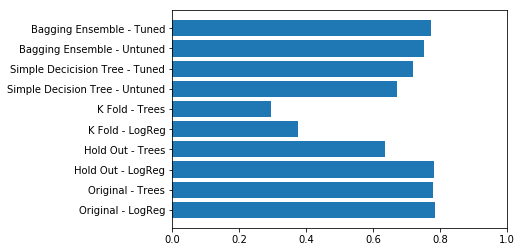

In [30]:
display(model_test_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

{'Original - LogReg': 0.7424999999999999,
 'Original - Trees': 0.7125,
 'Hold Out - LogReg': 0.7325,
 'Hold Out - Trees': 0.55,
 'K Fold - LogReg': 0.3825,
 'K Fold - Trees': 0.27749999999999997,
 'Single Decision Tree - Untuned': 0.5974999999999999,
 'Single Decision Tree - Tuned': 0.58,
 'Bagging Ensemble - Untuned': 0.6024999999999999,
 'Bagging Ensemble - Tuned': 0.595}

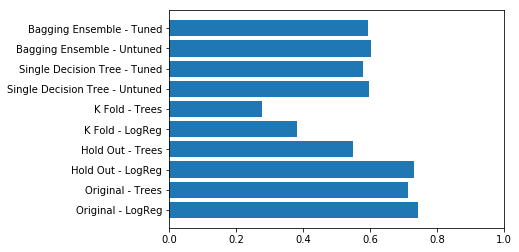

In [31]:
display(model_cv_test_mean_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_test_mean_accuracy_comparisons)), list(model_cv_test_mean_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_test_mean_accuracy_comparisons)), list(model_cv_test_mean_accuracy_comparisons.keys()))

{'Original - LogReg': 0.014790199457749054,
 'Original - Trees': 0.027726341266023535,
 'Hold Out - LogReg': 0.04968651728587948,
 'Hold Out - Trees': 0.05385164807134504,
 'K Fold - LogReg': 0.047631397208144126,
 'K Fold - Trees': 0.0511737237261468,
 'Single Decision Tree - Untuned': 0.016393596310755015,
 'Single Decision Tree - Tuned': 0.04301162633521313,
 'Bagging Ensemble - Untuned': 0.024874685927665518,
 'Bagging Ensemble - Tuned': 0.04272001872658766}

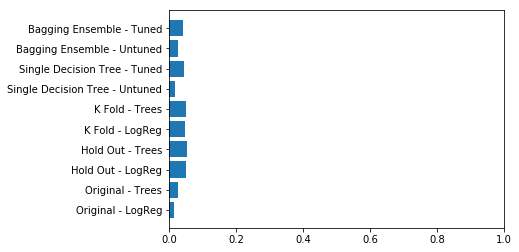

In [32]:
display(model_cv_test_std_dev_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_test_std_dev_accuracy_comparisons)), list(model_cv_test_std_dev_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_test_std_dev_accuracy_comparisons)), list(model_cv_test_std_dev_accuracy_comparisons.keys()))

## Task 5: Implement the StackedEnsembleOneVsOne Class

### Model 6: StackedEnsembleOneVsOne
#### 6.1 Logistic Regression Stack Layer

In [33]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierOnevOneLogReg(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and an aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_type = "svg", stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_type: The types of classifiers to include at the base layer
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_type = base_estimator_type
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
                
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
    
        unique_classes = range(0,10)
        for class_combo in combinations(unique_classes, 2):
            
            # Create the new dataset with isolated classes
            onevsone_df = train[train['label'].isin(class_combo)]    
            X_onevsone = onevsone_df[onevsone_df.columns[1:]]
            y_onevsone = np.array(onevsone_df["label"])                

            # Create the classifier object
            classifier = create_classifier(self.base_estimator_type, tree_min_samples_split=math.ceil(len(X)*0.05))

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_onevsone, y_onevsone, replace=True)    

            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)

            # Make predictions for all instances in the entire dataset
            y_pred_onevsone = classifier.predict_proba(X) 

            # Append the predictions to the stack layer training set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred_onevsone]
            except ValueError:
                self.X_stack_train = y_pred_onevsone
                
            self.classifiers_.append(classifier)

        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)
                          
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

#### 6.2 Decision Tree Stack Layer

In [34]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifierOnevOneTrees(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and an aggregation model at the aggregation layer. A k-fold cross validation is used to generate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the base layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_type = "svg", stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_type: The types of classifiers to include at the base layer
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_type = base_estimator_type
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifiers in the ensemble
        self.classifiers_ = list()
                
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
    
        unique_classes = range(0,10)
        for class_combo in combinations(unique_classes, 2):
            
            # Create the new dataset with isolated classes
            onevsone_df = train[train['label'].isin(class_combo)]    
            X_onevsone = onevsone_df[onevsone_df.columns[1:]]
            y_onevsone = np.array(onevsone_df["label"])                

            # Create the classifier object
            classifier = create_classifier(self.base_estimator_type, tree_min_samples_split=math.ceil(len(X)*0.05))

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_onevsone, y_onevsone, replace=True)    

            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)

            # Make predictions for all instances in the entire dataset
            y_pred_onevsone = classifier.predict_proba(X) 

            # Append the predictions to the stack layer training set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred_onevsone]
            except ValueError:
                self.X_stack_train = y_pred_onevsone
                
            self.classifiers_.append(classifier)

        print(self.X_stack_train.shape)
        print(self.y_stack_train.shape)
                          
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check if fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
           
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the templates_ dictionary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

### Test the StackedEnsembleOneVsOne
#### 6.1 Logistic Regression Stack Layer

In [35]:
clf = StackedEnsembleClassifierOnevOneLogReg()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["One vs One - LogReg"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["One vs One - LogReg"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["One vs One - LogReg"] = accuracy

(1600, 90)
(1600,)
(300, 90)
(300,)
(300, 90)
(300,)
(300, 90)
(300,)
(300, 90)
(300,)


#### 6.2 Decision Trees Stack Layer

In [36]:
clf = StackedEnsembleClassifierOnevOneTrees()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

scores = cross_val_score(clf, X_test, y_test, cv=cv_folds)
model_cv_test_mean_accuracy_comparisons["One vs One - Trees"] = np.mean(scores)
model_cv_test_std_dev_accuracy_comparisons["One vs One - Trees"] = np.std(scores)

accuracy = metrics.accuracy_score(y_test, y_pred) 
model_test_accuracy_comparisons["One vs One - Trees"] = accuracy

(1600, 90)
(1600,)
(300, 90)
(300,)
(300, 90)
(300,)
(300, 90)
(300,)
(300, 90)
(300,)


## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

{'Original - LogReg': 0.785,
 'Original - Trees': 0.7775,
 'Hold Out - LogReg': 0.7825,
 'Hold Out - Trees': 0.635,
 'K Fold - LogReg': 0.375,
 'K Fold - Trees': 0.295,
 'Simple Decision Tree - Untuned': 0.67,
 'Simple Decicision Tree - Tuned': 0.7175,
 'Bagging Ensemble - Untuned': 0.7525,
 'Bagging Ensemble - Tuned': 0.7725,
 'One vs One - LogReg': 0.6925,
 'One vs One - Trees': 0.6925}

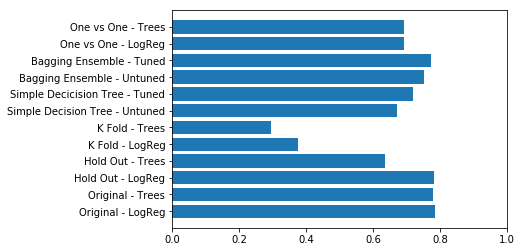

In [37]:
display(model_test_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

{'Original - LogReg': 0.7424999999999999,
 'Original - Trees': 0.7125,
 'Hold Out - LogReg': 0.7325,
 'Hold Out - Trees': 0.55,
 'K Fold - LogReg': 0.3825,
 'K Fold - Trees': 0.27749999999999997,
 'Single Decision Tree - Untuned': 0.5974999999999999,
 'Single Decision Tree - Tuned': 0.58,
 'Bagging Ensemble - Untuned': 0.6024999999999999,
 'Bagging Ensemble - Tuned': 0.595,
 'One vs One - LogReg': 0.59,
 'One vs One - Trees': 0.615}

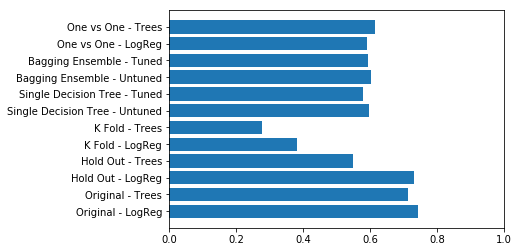

In [38]:
display(model_cv_test_mean_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_test_mean_accuracy_comparisons)), list(model_cv_test_mean_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_test_mean_accuracy_comparisons)), list(model_cv_test_mean_accuracy_comparisons.keys()))

{'Original - LogReg': 0.014790199457749054,
 'Original - Trees': 0.027726341266023535,
 'Hold Out - LogReg': 0.04968651728587948,
 'Hold Out - Trees': 0.05385164807134504,
 'K Fold - LogReg': 0.047631397208144126,
 'K Fold - Trees': 0.0511737237261468,
 'Single Decision Tree - Untuned': 0.016393596310755015,
 'Single Decision Tree - Tuned': 0.04301162633521313,
 'Bagging Ensemble - Untuned': 0.024874685927665518,
 'Bagging Ensemble - Tuned': 0.04272001872658766,
 'One vs One - LogReg': 0.014142135623730963,
 'One vs One - Trees': 0.03500000000000003}

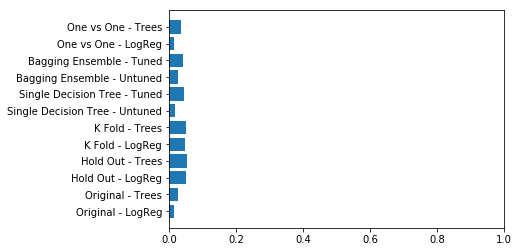

In [39]:
display(model_cv_test_std_dev_accuracy_comparisons)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_cv_test_std_dev_accuracy_comparisons)), list(model_cv_test_std_dev_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_cv_test_std_dev_accuracy_comparisons)), list(model_cv_test_std_dev_accuracy_comparisons.keys()))

## Task 7 Reflect on the Performance of the Different Models Evaluated

When we compare the cross validated mean accuracy rate for each model, the original classification model produced the results with the highest accuracy. It also has the second lowest cross validated standard deviation. This means that it predicted the correct class better than any other model with the lowest variance. 

The original model is a straightforward stacking model, that generates the values in the stacked layer by training the model on the entire training set and predicting the same training set. As such, there is a high risk of overfitting. This clearly did not seem to be an issue as this model was able to generalize very well relative to the other implementations.
The idea behind the Hold out and the K-Fold implementations was to avoid this overfitting risk by generating the stacked training set with predictions on unseen data. In our case, this didn’t seem to improve the models at all. 

The idea behind the One versus One implementation was to build specialist learners that could accurately predict certain classes. This likely hasn’t worked in our case due to the data restrictions, there were only 160 instances of each class in the dataset.

We note that the Hold out, K Fold and One versus One implementation’s were not guaranteed to outperform the simple model, particularly in the case of low numbers of training examples. This dataset is heavily downsized and contains a mere 1600 training values.

At the stack layer, the Logistic Regression classifier outperformed the Decision Trees classifier for each implementation. The main difference between the two is their decision boundaries. Decision trees produce a non-linear decision boundary versus a single linear boundary for the Logistic Regression. As such, the single line decision boundary was better suited to this image classification problem. 
